In [1]:
## Load packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scipy import stats
import bisect
import warnings
warnings.filterwarnings('ignore')

from xgboost.sklearn import XGBRegressor
from sklearn import model_selection, preprocessing
import xgboost as xgb

%matplotlib inline

In [2]:
#timestamp:from object to datetime64[ns]
train_df = pd.read_csv('train.csv', parse_dates=['timestamp'])
test_df = pd.read_csv('test.csv', parse_dates=['timestamp'])
macro_df = pd.read_csv('macro.csv', parse_dates=['timestamp'])

In [3]:
print(train_df.columns)
print(train_df.shape)
print(test_df.shape)

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=292)
(30471, 292)
(7662, 291)


In [4]:
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64


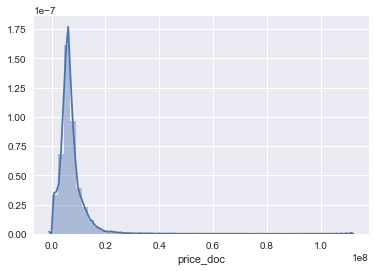

In [5]:
## Describe the output field
print(train_df['price_doc'].describe())
sns.distplot(train_df['price_doc'])

In [6]:
# #new col:LogAmt
# train_df['LogAmt']=np.log(train_df.price_doc+1.0)
# print(train_df['LogAmt'].describe())
# sns.distplot(train_df['LogAmt'])

In [7]:
#new col:Source
train_cp = train_df.copy()
train_cp['Source']='Train'
test_cp = test_df.copy()
test_cp['Source']='Test'
alldata = pd.concat([train_cp, test_cp],ignore_index=True)

In [8]:
alldata.shape

(38133, 293)

In [9]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38133 entries, 0 to 38132
Columns: 293 entries, 0_13_all to zd_vokzaly_avto_km
dtypes: datetime64[ns](1), float64(121), int64(155), object(16)
memory usage: 85.2+ MB


In [10]:
alldata.columns

Index(['0_13_all', '0_13_female', '0_13_male', '0_17_all', '0_17_female',
       '0_17_male', '0_6_all', '0_6_female', '0_6_male', '16_29_all',
       ...
       'water_km', 'water_treatment_km', 'work_all', 'work_female',
       'work_male', 'workplaces_km', 'young_all', 'young_female', 'young_male',
       'zd_vokzaly_avto_km'],
      dtype='object', length=293)

In [11]:
macro_df.columns 

Index(['timestamp', 'oil_urals', 'gdp_quart', 'gdp_quart_growth', 'cpi', 'ppi',
       'gdp_deflator', 'balance_trade', 'balance_trade_growth', 'usdrub',
       'eurrub', 'brent', 'net_capital_export', 'gdp_annual',
       'gdp_annual_growth', 'average_provision_of_build_contract',
       'average_provision_of_build_contract_moscow', 'rts', 'micex',
       'micex_rgbi_tr', 'micex_cbi_tr', 'deposits_value', 'deposits_growth',
       'deposits_rate', 'mortgage_value', 'mortgage_growth', 'mortgage_rate',
       'grp', 'grp_growth', 'income_per_cap',
       'real_dispos_income_per_cap_growth', 'salary', 'salary_growth',
       'fixed_basket', 'retail_trade_turnover',
       'retail_trade_turnover_per_cap', 'retail_trade_turnover_growth',
       'labor_force', 'unemployment', 'employment',
       'invest_fixed_capital_per_cap', 'invest_fixed_assets',
       'profitable_enterpr_share', 'unprofitable_enterpr_share',
       'share_own_revenues', 'overdue_wages_per_cap', 'fin_res_per_cap',
    

In [12]:
macro_df.columns = ['mac__'+c if c!='timestamp' else 'timestamp' for c in macro_df.columns ]
#macro_df.columns

In [13]:
#merge by timestamp
alldata=alldata.merge(macro_df,on='timestamp',how='left')
alldata.shape
#alldata.columns

(38133, 392)

In [14]:
alldata_dtype=alldata.dtypes
display_nvar = len(alldata.columns)
#display_nvar

In [15]:
alldata_dtype_dict = alldata_dtype.to_dict()
alldata.dtypes.value_counts()

float64           215
int64             157
object             19
datetime64[ns]      1
dtype: int64

In [16]:
def var_desc(dt,alldata):
    print('--------------------------------------------')
    for c in alldata.columns:
        if alldata[c].dtype==dt:
            t1 = alldata[alldata.Source=='Train'][c]
            t2 = alldata[alldata.Source=='Test'][c]
            if dt=="object":
                f1 = t1[pd.isnull(t1)==False].value_counts()
                f2 = t2[pd.isnull(t2)==False].value_counts()
            else:
                f1 = t1[pd.isnull(t1)==False].describe()
                f2 = t2[pd.isnull(t2)==False].describe()
            m1 = t1.isnull().value_counts()
            m2 = t2.isnull().value_counts()
            f = pd.concat([f1, f2], axis=1)
            m = pd.concat([m1, m2], axis=1)
            f.columns=['Train','Test']
            m.columns=['Train','Test']
            print(dt+' - '+c)
            print('UniqValue - ',len(t1.value_counts()),len(t2.value_counts()))
            print(f.sort_values(by='Train',ascending=False))
            print()

            m_print=m[m.index==True]
            if len(m_print)>0:
                print('missing - '+c)
                print(m_print)
            else:
                print('NO Missing values - '+c)
            if dt!="object":
                if len(t1.value_counts())<=10:
                    c1 = t1.value_counts()
                    c2 = t2.value_counts()
                    c = pd.concat([c1, c2], axis=1)
                    f.columns=['Train','Test']
                    print(c)
            print('--------------------------------------------')

In [17]:
#var_desc('object',alldata)

In [18]:
#cols type from object to int
for f in alldata.columns:
    if f not in ['timestamp','Source']:
        if alldata[f].dtype=='object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(alldata[f].values)) 
            alldata[f] = lbl.transform(list(alldata[f].values))

In [19]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38133 entries, 0 to 38132
Columns: 392 entries, 0_13_all to mac__apartment_fund_sqm
dtypes: datetime64[ns](1), float64(215), int64(175), object(1)
memory usage: 114.3+ MB


In [20]:
## missing values
missing_col = [[c,sum(alldata[alldata.Source=='Train'][c].isnull()==True),sum(alldata[alldata.Source=='Test'][c].isnull()==True)] for c in alldata.columns]
missing_col = pd.DataFrame(missing_col,columns=['Var','missingTrain','missingTest'])

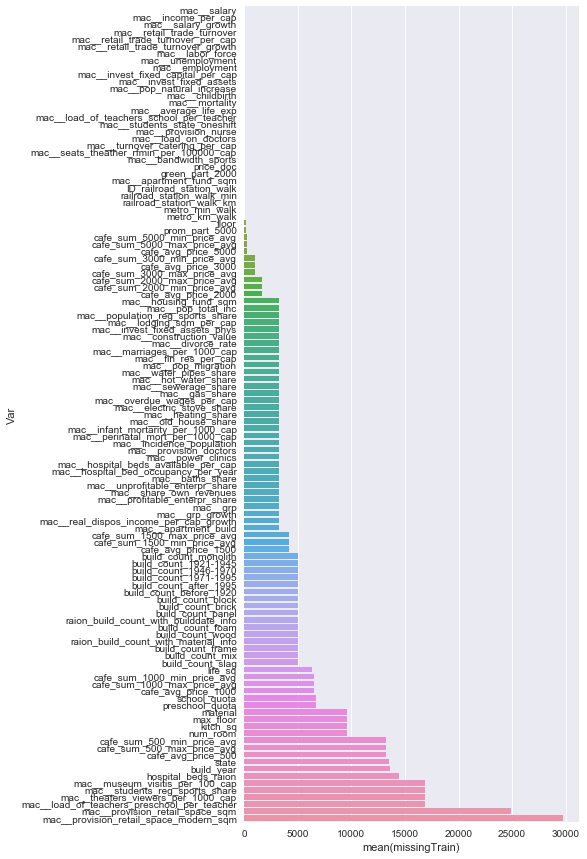

In [21]:
missingdf=missing_col[missing_col.missingTrain+missing_col.missingTest>0]
missingdf=missingdf.sort('missingTrain')
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(y=missingdf.Var,x=missingdf.missingTrain)

In [20]:
excl_col=['id','timestamp','sub_area'] + [c for c in alldata.columns if alldata[c].dtype=='object']
resv_col=['price_doc','Source','cafe_sum_500_max_price_avg','cafe_sum_500_min_price_avg',
          'cafe_avg_price_500','hospital_beds_raion']
excl_col
#'LogAmt',

['id', 'timestamp', 'sub_area', 'Source']

In [21]:
def sel_grp(keys):
    lst_all = list()
    for k in keys:
        lst = [c for c in alldata.columns if c.find(k)!=-1 and c not in excl_col and c not in resv_col]
        lst = list(set(lst))
        lst_all += lst
    return(lst_all)

In [22]:
col_grp = dict({})
col_grp['people']=sel_grp(['_all','male'])
col_grp['id'] = sel_grp(['ID_'])
col_grp['church']=sel_grp(['church'])
col_grp['build']=sel_grp(['build_count_'])
col_grp['cafe']=sel_grp(['cafe_count'])
col_grp['cafeprice']=sel_grp(['cafe_sum','cafe_avg'])
col_grp['km']=sel_grp(['_km','metro_min','_avto_min','_walk_min','_min_walk'])
col_grp['mosque']=sel_grp(['mosque_count'])
col_grp['market']=sel_grp(['market_count'])
col_grp['office']=sel_grp(['office_count'])
col_grp['leisure']=sel_grp(['leisure_count'])
col_grp['sport']=sel_grp(['sport_count'])
col_grp['green']=sel_grp(['green_part'])
col_grp['prom']=sel_grp(['prom_part'])
col_grp['trc']=sel_grp(['trc_count'])
col_grp['sqm']=sel_grp(['_sqm_'])
col_grp['raion']=sel_grp(['_raion'])
col_grp['macro']=sel_grp(['mac__'])
col_grp.keys()

dict_keys(['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro'])

In [23]:
col_grp['people']

['young_all',
 '16_29_all',
 'work_all',
 '0_17_all',
 '7_14_all',
 'full_all',
 '0_6_all',
 '0_13_all',
 'ekder_all',
 '7_14_male',
 'ekder_male',
 '0_17_female',
 '0_13_female',
 'young_male',
 'work_male',
 '0_17_male',
 '16_29_female',
 '7_14_female',
 '0_6_female',
 'ekder_female',
 'female_f',
 'male_f',
 'work_female',
 'young_female',
 '16_29_male',
 '0_6_male',
 '0_13_male']

In [24]:
col_tmp = list()
for d in col_grp:
    col_tmp+=(col_grp[d])
col_grp['other']=[c for c in alldata.columns if c not in col_tmp and c not in excl_col and c not in resv_col]
col_grp['other'] 

['area_m',
 'big_road1_1line',
 'build_year',
 'children_preschool',
 'children_school',
 'culture_objects_top_25',
 'ecology',
 'floor',
 'full_sq',
 'green_zone_part',
 'indust_part',
 'kitch_sq',
 'life_sq',
 'material',
 'max_floor',
 'num_room',
 'preschool_quota',
 'product_type',
 'railroad_1line',
 'raion_popul',
 'school_quota',
 'state',
 'water_1line']

In [25]:
macro_missing_2 = pd.DataFrame([[c,sum(alldata[c].isnull())] for c in col_grp['macro']],columns=['Var','Missing'])
macro_missing_3=macro_missing_2[macro_missing_2.Missing>5000]
print(macro_missing_3)
excl_col+=list(macro_missing_3.Var)
print(excl_col)

col_grp['macro']=sel_grp(['mac__'])

                                            Var  Missing
2                     mac__incidence_population    10901
3                                mac__gas_share    10901
4        mac__real_dispos_income_per_cap_growth    10901
5                          mac__old_house_share    10901
6              mac__perinatal_mort_per_1000_cap    10901
7               mac__unprofitable_enterpr_share    10901
8               mac__museum_visitis_per_100_cap    24563
10                                     mac__grp    10901
11                  mac__marriages_per_1000_cap    10901
13                        mac__housing_fund_sqm    10901
18                             mac__baths_share    10901
23       mac__provision_retail_space_modern_sqm    37380
24  mac__load_of_teachers_preschool_per_teacher    24563
25               mac__students_reg_sports_share    24563
26                           mac__heating_share    10901
28                      mac__construction_value    10901
31              mac__provision_

In [26]:
loopkeys=list(col_grp.keys())
print(loopkeys)

['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro', 'other']


In [27]:
def partial_pca(var,data,col_grp):
    pca = PCA()
    df = data[col_grp[var]].dropna()
    print([len(data[col_grp[var]]), len(df)])
    df = (df-df.mean())/df.std(ddof=0)
    pca.fit(df)
    varexp = pca.explained_variance_ratio_.cumsum()
    cutoff = bisect.bisect(varexp, 0.95)
    #print(cutoff)
    #print(pca.explained_variance_ratio_.cumsum())
    newcol=pd.DataFrame(pca.fit_transform(X=df)[:,0:(cutoff+1)],columns=['PCA_'+var+'_'+str(i) for i in range(cutoff+1)],index=df.index)
    #print(newcol)
    col_grp['PCA_'+var]=list(newcol.columns)
    return(newcol,col_grp,pca)

In [28]:
alldata.shape

(38133, 392)

In [29]:
for c in loopkeys:
    if c!='other':
        print(c)
        newcol,col_grp,pca = partial_pca(c,alldata,col_grp)
        alldata=alldata.join(newcol)
        print(alldata.shape)
        print(col_grp.keys())

people
[38133, 38133]
(38133, 394)
dict_keys(['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro', 'other', 'PCA_people'])
id
[38133, 38074]
(38133, 400)
dict_keys(['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro', 'other', 'PCA_people', 'PCA_id'])
church
[38133, 38133]
(38133, 404)
dict_keys(['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro', 'other', 'PCA_people', 'PCA_id', 'PCA_church'])
build
[38133, 31924]
(38133, 411)
dict_keys(['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro', 'other', 'PCA_people', 'PCA_id', 'PCA_church', 'PCA_build'])
cafe
[3813

In [30]:
wpca=list()
wopca=list()
for c in col_grp.keys():
    if c.find('PCA_')!=-1:
        wpca+=col_grp[c]
    else:
        wopca+=col_grp[c]
        
wpca+=col_grp['other']
wpca+=resv_col
wopca+=col_grp['other']
wopca+=resv_col

wpca=list(set(wpca))
wopca=list(set(wopca))

wpca.sort()
wopca.sort()

In [31]:
len(wpca)

131

In [32]:
col_grp.keys()

dict_keys(['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro', 'other', 'PCA_people', 'PCA_id', 'PCA_church', 'PCA_build', 'PCA_cafe', 'PCA_cafeprice', 'PCA_km', 'PCA_mosque', 'PCA_market', 'PCA_office', 'PCA_leisure', 'PCA_sport', 'PCA_green', 'PCA_prom', 'PCA_trc', 'PCA_sqm', 'PCA_raion', 'PCA_macro'])

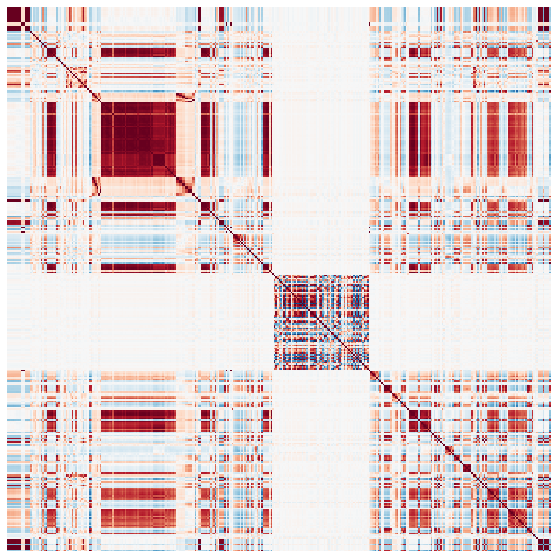

In [33]:
corrmat = alldata[wopca].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True,xticklabels=False,yticklabels=False,cbar=False,annot=False);

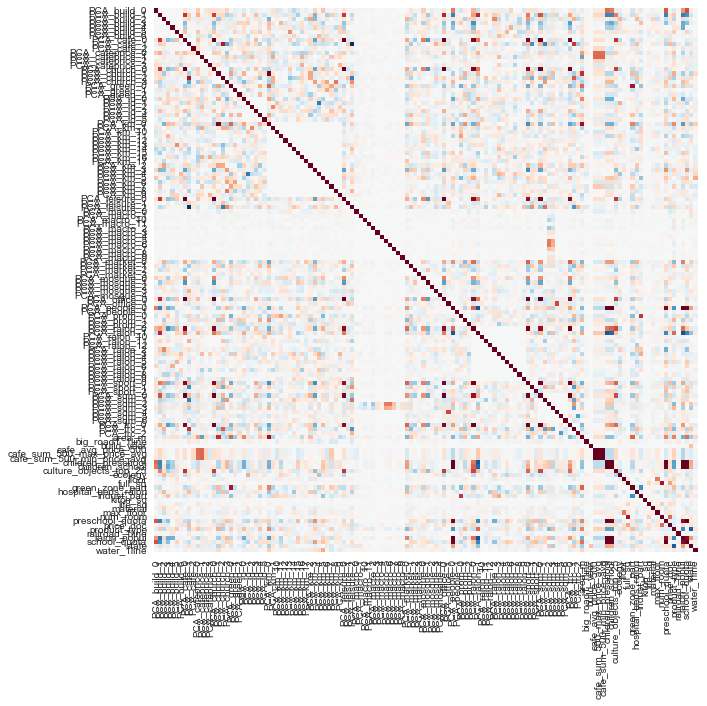

In [34]:
## Correlation with PCA
corrmat = alldata[wpca].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True,xticklabels=True,yticklabels=True,cbar=False,annot=False);

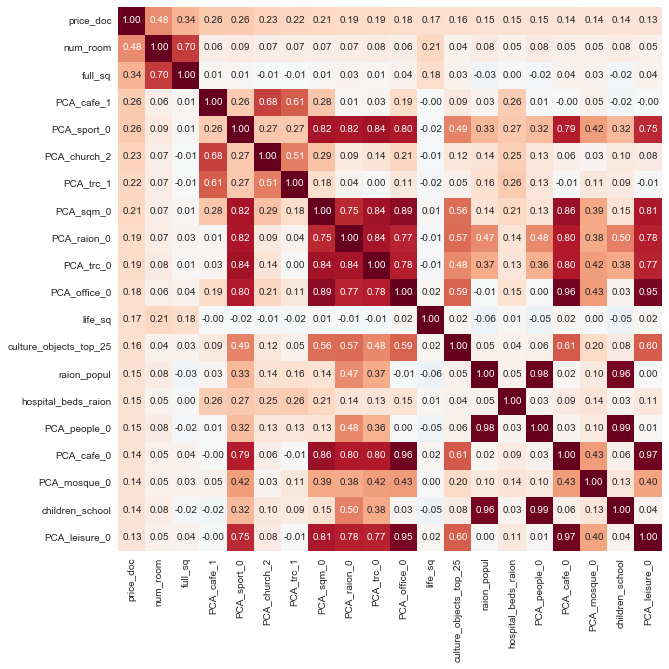

In [35]:
## Top 20 correlated variables
corrmat = alldata[wpca].corr()
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price_doc')['price_doc'].index
cm = alldata[cols].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [36]:
## Add a few more features suggested by other discussions
##
# Add month-year
month_year = (alldata.timestamp.dt.month + alldata.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
alldata['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (alldata.timestamp.dt.weekofyear + alldata.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
alldata['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
alldata['month'] = alldata.timestamp.dt.month
alldata['dow'] = alldata.timestamp.dt.dayofweek

# Other feature engineering
alldata['rel_floor'] = alldata['floor'] / alldata['max_floor'].astype(float)
alldata['rel_kitch_sq'] = alldata['kitch_sq'] / alldata['full_sq'].astype(float)

In [37]:
wpca +=['month_year_cnt','week_year_cnt','dow','month','rel_floor','rel_kitch_sq']
wopca+=['month_year_cnt','week_year_cnt','dow','month','rel_floor','rel_kitch_sq']
allfeature=list(set(wpca+wopca))

In [38]:
train_col = [c for c in alldata[wpca].columns if c not in ['Source']]
train_final = alldata[alldata.Source=='Train'][train_col]
X_train = train_final.drop('price_doc',axis=1)
Y_train = train_final.price_doc
X_test = alldata[alldata.Source=='Test'][train_col].drop('price_doc',axis=1)

In [46]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}
# xgb_params = {
#     'eta': 0.05,
#     'max_depth': 12,
#     'subsample': 1,
#     'colsample_bytree': 0.7,
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse',
#     'silent': 1,
#     'min_child_weight': 200
# }
dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test)

In [47]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, nfold=5,
    verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.20765e+06	test-rmse:8.20882e+06
[50]	train-rmse:2.83215e+06	test-rmse:2.99238e+06
[100]	train-rmse:2.58189e+06	test-rmse:2.82911e+06
[150]	train-rmse:2.48251e+06	test-rmse:2.78644e+06
[200]	train-rmse:2.41179e+06	test-rmse:2.76367e+06
[250]	train-rmse:2.35053e+06	test-rmse:2.74749e+06
[300]	train-rmse:2.29711e+06	test-rmse:2.73759e+06
[350]	train-rmse:2.24594e+06	test-rmse:2.72822e+06
[400]	train-rmse:2.20219e+06	test-rmse:2.72297e+06
[450]	train-rmse:2.16008e+06	test-rmse:2.71642e+06
[500]	train-rmse:2.12095e+06	test-rmse:2.71361e+06
[550]	train-rmse:2.08431e+06	test-rmse:2.71038e+06
[600]	train-rmse:2.04782e+06	test-rmse:2.70804e+06
[650]	train-rmse:2.01462e+06	test-rmse:2.70574e+06
[700]	train-rmse:1.98268e+06	test-rmse:2.70296e+06
[750]	train-rmse:1.95187e+06	test-rmse:2.70138e+06
[800]	train-rmse:1.92031e+06	test-rmse:2.70044e+06
[850]	train-rmse:1.89146e+06	test-rmse:2.699e+06


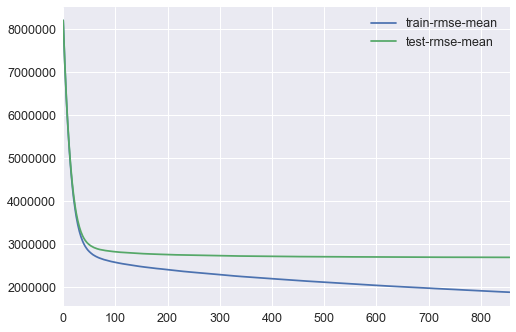

In [48]:
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.show()

In [49]:
num_boost_rounds = len(cv_output)
num_boost_rounds

856

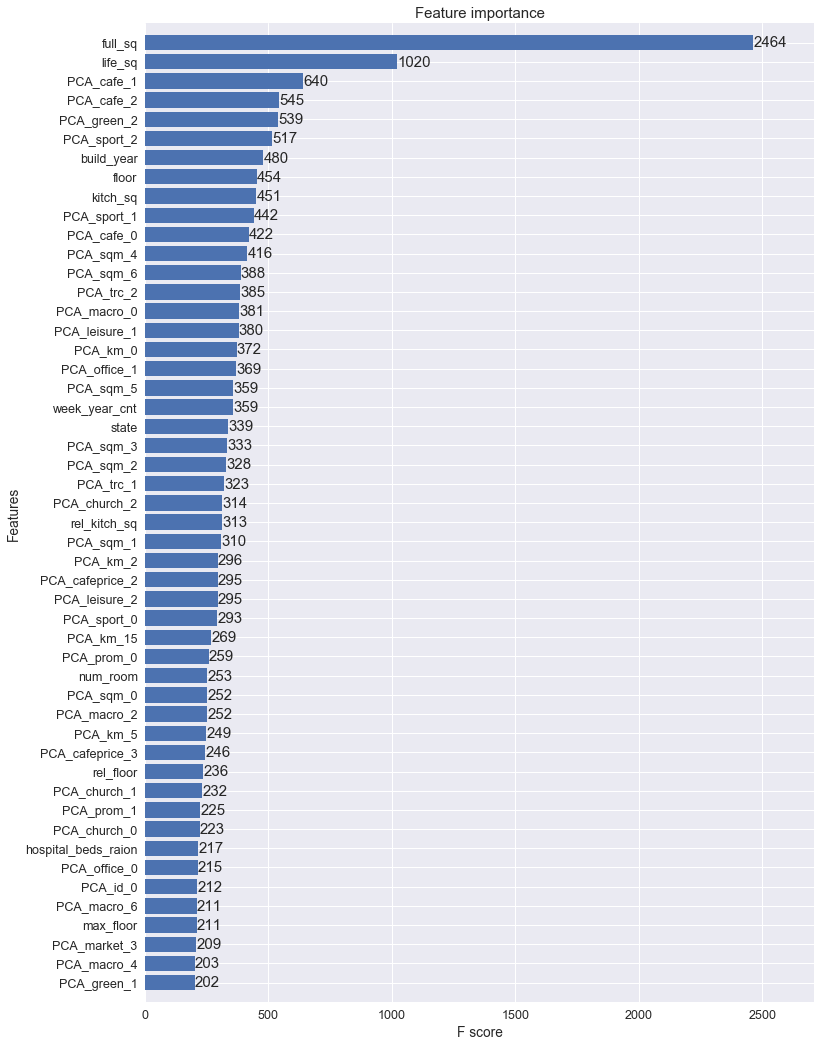

In [50]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [51]:
preds = model.predict(dtest)
id_test = alldata[alldata.Source=='Test'].id
output = pd.DataFrame({'id': id_test, 'price_doc': preds})
output.head()

,id,price_doc
30471,30474,5593407.5
30472,30475,8890916.0
30473,30476,5732471.0
30474,30477,6755245.5
30475,30478,5349308.5


In [45]:
output.to_csv('xgb_pca_v3_rm_subarea.csv', index=False)